In [1]:
from __future__ import print_function
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image

%matplotlib inline
import matplotlib.pyplot as plt
from torch.distributions.multivariate_normal import MultivariateNormal
import numpy as np


from sklearn.manifold import TSNE
from random import random
from sklearn.mixture import GaussianMixture
from sklearn.mixture import BayesianGaussianMixture

In [2]:
batch_size = 100
take_latent_max =10
num_epoch = 10
input_dim=28*28
output_dim=input_dim
en_hidden1_dim = 400
latent_dim= 20
de_hidden1_dim = 400
log_interval = 10

K_model_cluster = 10

beta= 1.



In [3]:
device = 'cuda'
kwargs = {'num_workers':1, 'pin_memory':True}

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data',train=True,download=True,
                   transform=transforms.ToTensor()),
    batch_size=batch_size,shuffle=True,**kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data',train=False,transform=transforms.ToTensor()),
    batch_size=batch_size,shuffle=True,**kwargs)

In [4]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.input_layer = nn.Linear(input_dim,en_hidden1_dim)
        self.mu_layer = nn.Linear(en_hidden1_dim,latent_dim)
        self.std_layer = nn.Linear(en_hidden1_dim,latent_dim)
        self.decode1_layer = nn.Linear(latent_dim,de_hidden1_dim)
        self.output_layer = nn.Linear(de_hidden1_dim,output_dim)

    def encode(self, x):
        h1 = F.relu(self.input_layer(x))
        return self.mu_layer(h1), self.std_layer(h1)
    #入力から中心と分散の対数を作っている

    def reparameterize(self,mu,logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        #torch.randn_like(std)はstdと同じ次元の正規乱数を与えている。N(0,1)**size(std).ただし、標準偏差は対角的。
        return mu + eps*std
    #zの値を確率的に作っている。

    def decode(self,z):
        h3 = F.relu(self.decode1_layer(z))
        return torch.sigmoid(self.output_layer(h3))
    #zからNNを通したあとに、sigmoidで押し込んでxの値を作っている

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1,784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z),mu,logvar,z
    #出力はxの予測値とzを算出するときの中心と分散になっている

model = VAE().to(device)
optimizer = optim.Adam(model.parameters(),lr=1e-3)

In [5]:
def loss_function(recon_x,x,mu,logvar):
    BCE = F.binary_cross_entropy(recon_x,x.view(-1,784),reduction='sum')
    #recon_xはsigmoidをdecordeで通されているので、[0,1]になっている。
    KLD = -0.5*torch.sum(1+logvar-mu.pow(2)-logvar.exp())

    return BCE+beta*KLD



In [6]:
def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data,_) in enumerate(train_loader):
        #ラベルは使わないようだ
        data = data.to(device)
        #データをGPUにおくる
        optimizer.zero_grad()
        #傾きの初期化
        recon_batch, mu, logvar,z = model(data)
        #VAEからバッヂ分のデータと中心と分散のログを受け取る
        loss = loss_function(recon_batch,data,mu,logvar)
        #バッヂ分のロスを計算。バッヂ数で割っていないようだ。書き出しのときにデータ数で割っている。
        loss.backward()
        #傾きを計算
        train_loss+= loss.item()
        optimizer.step()
        #パラメータの更新
        if batch_idx % log_interval ==0:
            #一定間隔でロスを書き出し。epochはここでしか使っていないようだ。
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
              epoch,batch_idx*len(data),len(train_loader.dataset),
                100.*batch_idx/len(train_loader),
                loss.item()/len(data)
            ))

In [7]:
def test(epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():#バックプロパゲーションを行わないから、微分情報を残さない
        for i, (data, _) in enumerate(test_loader):
            #テストデータを取り出す。ラベルはいらない。
            data =data.to(device)
            #データをGPUに送る
            recon_batch, mu, logvar,z = model(data)
            #データからバッヂ分の再現画像と中心と分散の対数を出している。
            test_loss += loss_function(recon_batch,data,mu,logvar).item()
            #テストデータでのロスを出している
            if i == 0:
                #はじめのバッヂについて
                n = min(data.size(0),16)
                #nをバッヂのデータ数か８との小さい方として
                comparizon = torch.cat([data[:n],recon_batch.view(batch_size,1,28,28)[:n]])
                #元データと再現データを並べる
                save_image(comparizon.cpu(),'./results/reconstruction_' + str(epoch) + '.png',nrow=n)

                test_loss /= len(test_loader.dataset)
                print('====> Test set loss: {:.4f}'.format(test_loss))

In [8]:
def initial_train(epochs):
    for epoch in range(1, epochs +1):
        train(epoch)
        test(epoch)
        with torch.no_grad():
            sample = torch.randn(64,latent_dim).to(device)
        #20次元の潜在空間のデータを64個作成して、GPUに送る
            sample = model.decode(sample).cpu()
        #ランダムな潜在変数から画像を生成する。
            save_image(sample.view(64,1,28,28),'results/sample_' + str(epoch) + '.png',nrow=8)
        #生成した６４個のデータを記録しておく


In [9]:
def take_latents():
    zs = torch.empty(0,latent_dim,1).to(device).requires_grad_(False)
    ts = torch.empty(0,dtype=torch.long).to(device).requires_grad_(False)
    mus = torch.empty(0,latent_dim,1).to(device).requires_grad_(False)
    logvars = torch.empty(0,latent_dim,1).to(device).requires_grad_(False)
#zs = []
#ts = []

#ts.dtype = torch.int

    #for x, t in test_loader:
    for batch_idx, (x,t) in enumerate(test_loader):
    # original。xがデータ、tがラベル。
    #for i, im in enumerate(x.view(-1, 28, 28).detach().numpy()[:10]):
    #  ax = fig.add_subplot(3, 10, i+1, xticks=[], yticks=[])
    #  ax.imshow(im, 'gray')
    #x = x.to(device)
    # generate from x
        if batch_idx < take_latent_max:
            x = x.to(device)
            with torch.no_grad():
                recon_batch,mu,logvar, z = model(x)
            t = t.to(device)
    #zs.append(z)
    #ts.append(t)
            zs = torch.cat((zs,z.view(-1,latent_dim,1)),0)
            ts = torch.cat((ts,t),0)
            mus = torch.cat((mus,mu.view(-1,latent_dim,1)),0)
            logvars = torch.cat((logvars,logvar.view(-1,latent_dim,1)),0)
    #y = y.view(-1, 28, 28)
    #for i, im in enumerate(y.cpu().detach().numpy()[:10]):
     # ax = fig.add_subplot(3, 10, i+11, xticks=[], yticks=[])
     # ax.imshow(im, 'gray')
    return zs,ts,mus,logvars

In [10]:
def initialize_centers(mus):

    mu_center = mus.mean(0,keepdim=True).detach().requires_grad_(False)
    mus_white = mus.detach().requires_grad_(False)-mu_center
    cov_mus = torch.matmul(mus_white.squeeze(2).t(),mus_white.squeeze(2))/mus.shape[0]

    mu_distribution = MultivariateNormal(loc=mu_center.view(-1,latent_dim),covariance_matrix=cov_mus)
#mu_distribution = MultivariateNormal(loc=mu_center.cpu(),covariance_matrix=cov_mus.cpu())
    mu_c = mu_distribution.sample([K_model_cluster,])
    mu_c = mu_c.permute(1,2,0)

    logvar_c = torch.diag(cov_mus).log()
    logvar_c = logvar_c.view(1,latent_dim,1)
#logvar_c = logvar_c.repeat(0,K_model_cluster)
    logvar_c = logvar_c.repeat(1,1,K_model_cluster)

    pi_c = torch.full((1,1,K_model_cluster),1./K_model_cluster).to(device).requires_grad_(False)

    return mu_c,logvar_c,pi_c

In [850]:
#zs_g,ts_g,mus_g,logvars_g,mu_c_g,logvar_c_g,pi_c_g = initialize_centers()

In [11]:
def gauss(mus,logvars,mu_c,logvar_c,pi_c,iter):
    #mus = mus_ini
    #logvars = logvars_ini
    #mu_c = mu_c_ini
    #logvar_c = logvar_c_ini
    #pi_c = pi_c_ini

    for i in range(iter):
        with torch.no_grad():
            Q_c = logvar_c+logvars.exp()/(logvar_c.exp())+(mus-mu_c).pow(2)/(logvar_c.exp())

            gamma_c = (pi_c*((-0.5*Q_c.sum(1,keepdim=True)).exp()))/(pi_c*((-0.5*Q_c.sum(1,keepdim=True)).exp())).sum(2,keepdim=True)

            N_c = gamma_c.sum(0,keepdim=True)
            log_P = (((pi_c*((-0.5*Q_c.sum(1,keepdim=True)).exp())).sum(2).squeeze()).log()).sum()/(Q_c.shape)[0]
            pi_c= N_c/N_c.sum()
            mu_c=(gamma_c*mus).sum(0,keepdim=True)/N_c
            logvar_c=((gamma_c*((mus-mu_c).pow(2)+logvars.exp())).sum(0,keepdim=True)/N_c).log()

    return mu_c,logvar_c,pi_c,Q_c,gamma_c,log_P

In [12]:
def drawpoints(mus_numpy,ts_numpy):
    colors = ["red", "green", "blue", "orange", "purple", "brown", "fuchsia", "grey", "olive", "lightblue"]
    for p,l in zip(points,ts_numpy):
        plt.scatter(p[0],p[1],marker="${}$".format(l),c=colors[l])

In [13]:
def show_generated_samples_c(mu_c,logvar_c):
    for i in range(K_model_cluster):
        with torch.no_grad():
            sample_dist = MultivariateNormal(loc=mu_c[:,:,i],covariance_matrix=torch.diag(logvar_c[0,:,i].exp()))
    #mu_distribution = MultivariateNormal(loc=mu_center.cpu(),covariance_matrix=cov_mus.cpu())
            sample = sample_dist.sample([64,])
#    sample = torch.randn(64,latent_dim).to(device)
        #20次元の潜在空間のデータを64個作成して、GPUに送る
            sample = model.decode(sample).cpu()
        #ランダムな潜在変数から画像を生成する。
            save_image(sample.view(64,1,28,28),'results/sample_c_' + str(i) + '.png',nrow=8)
        #生成した６４個のデータを記録しておく

In [14]:
def loss_function_c(recon_x,x,mus_f,logvars_f,mu_c_f,logvar_c_f,pi_c_f):
    BCE = F.binary_cross_entropy(recon_x,x.view(-1,784),reduction='sum')
    #recon_xはsigmoidをdecordeで通されているので、[0,1]になっている。
    #KLD = -0.5*torch.sum(1+logvar-mu.pow(2)-logvar.exp())
    #Q_c_f = -logvars_f+logvar_c_f+logvars_f.exp()/(logvar_c_f.exp())+(mus_f-mu_c_f).pow(2)/(logvar_c_f.exp())
    #KLD = (((pi_c_f*((-0.5*(-logvars_f+logvar_c_f+logvars_f.exp()/(logvar_c_f.exp())+(mus_f-mu_c_f).pow(2)/(logvar_c_f.exp())).sum(1,keepdim=True)).exp())).sum(2).squeeze()).log()).sum()
    KLD = -0.5*(1+logvars_f).sum() -(((pi_c_f*(-0.5*((logvar_c_f+(logvars_f.exp()+(mus_f-mu_c_f).pow(2))/logvar_c_f.exp()).sum(1,keepdim=True))).exp()).sum(2,keepdim=True)).log()).sum()#+(logvars_f.exp()+(mus_f-mu_c_f).pow(2))/(logvar_c_f.exp()))

    return BCE+beta*KLD

In [15]:
def train_c(epoch,mu_c,logvar_c,pi_c):
    model.train()
    train_loss = 0
    for batch_idx, (data,_) in enumerate(train_loader):
        #ラベルは使わないようだ
        data = data.to(device)
        #データをGPUにおくる
        optimizer.zero_grad()
        #傾きの初期化
        recon_batch, mu, logvar,z = model(data)
        #VAEからバッヂ分のデータと中心と分散のログを受け取る
        loss = loss_function_c(recon_x=recon_batch,x=data,mus_f=mu.view(-1,latent_dim,1),logvars_f=logvar.view(-1,latent_dim,1),mu_c_f=mu_c,logvar_c_f=logvar_c,pi_c_f=pi_c)
        #バッヂ分のロスを計算。バッヂ数で割っていないようだ。書き出しのときにデータ数で割っている。
        loss.backward()
        #傾きを計算
        train_loss+= loss.item()
        optimizer.step()
        #パラメータの更新
        if batch_idx % log_interval ==0:
            #一定間隔でロスを書き出し。epochはここでしか使っていないようだ。len()は最初の次元の大きさを出すのでバッヂの大きさ。
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
              epoch,batch_idx*len(data),len(train_loader.dataset),
                100.*batch_idx/len(train_loader),
                loss.item()/len(data)
            ))

In [16]:
def test_c(epoch,mu_c,logvar_c,pi_c):
    model.eval()
    test_loss = 0
    with torch.no_grad():#バックプロパゲーションを行わないから、微分情報を残さない
        for i, (data, _) in enumerate(test_loader):
            #テストデータを取り出す。ラベルはいらない。
            data =data.to(device)
            #データをGPUに送る
            recon_batch, mu, logvar,z = model(data)
            #データからバッヂ分の再現画像と中心と分散の対数を出している。
            test_loss += loss_function_c(recon_x=recon_batch,x=data,mus_f=mu.view(-1,latent_dim,1),logvars_f=logvar.view(-1,latent_dim,1),mu_c_f=mu_c,logvar_c_f=logvar_c,pi_c_f=pi_c).item()
            #テストデータでのロスを出している
            if i == 0:
                #はじめのバッヂについて
                n = min(data.size(0),16)
                #nをバッヂのデータ数か８との小さい方として
                comparizon = torch.cat([data[:n],recon_batch.view(batch_size,1,28,28)[:n]])
                #元データと再現データを並べる
                save_image(comparizon.cpu(),'./results/reconstruction_c_' + str(epoch) + '.png',nrow=n)

                test_loss /= len(test_loader.dataset)
                print('====> Test set loss: {:.4f}'.format(test_loss))

In [17]:
def train_c_epoch(epochs,mu_c,logvar_c,pi_c):
    for epoch in range(1, epochs +1):
        train_c(epoch,mu_c,logvar_c,pi_c)
        test_c(epoch,mu_c,logvar_c,pi_c)
        with torch.no_grad():
            sample = torch.randn(64,latent_dim).to(device)
        #20次元の潜在空間のデータを64個作成して、GPUに送る
            sample = model.decode(sample).cpu()
        #ランダムな潜在変数から画像を生成する。
            save_image(sample.view(64,1,28,28),'results/sample_c_epoch_' + str(epoch) + '.png',nrow=8)
        #生成した６４個のデータを記録しておく

In [18]:
initial_train(3)

Train Epoch: 1 [0/60000 (0%)]	Loss: 549.909102
Train Epoch: 1 [1000/60000 (2%)]	Loss: 311.415039
Train Epoch: 1 [2000/60000 (3%)]	Loss: 235.766406
Train Epoch: 1 [3000/60000 (5%)]	Loss: 228.090508
Train Epoch: 1 [4000/60000 (7%)]	Loss: 219.564434
Train Epoch: 1 [5000/60000 (8%)]	Loss: 210.802812
Train Epoch: 1 [6000/60000 (10%)]	Loss: 202.591914
Train Epoch: 1 [7000/60000 (12%)]	Loss: 200.446465
Train Epoch: 1 [8000/60000 (13%)]	Loss: 195.461953
Train Epoch: 1 [9000/60000 (15%)]	Loss: 188.026484
Train Epoch: 1 [10000/60000 (17%)]	Loss: 175.009648
Train Epoch: 1 [11000/60000 (18%)]	Loss: 173.896289
Train Epoch: 1 [12000/60000 (20%)]	Loss: 166.893652
Train Epoch: 1 [13000/60000 (22%)]	Loss: 176.647051
Train Epoch: 1 [14000/60000 (23%)]	Loss: 164.294961
Train Epoch: 1 [15000/60000 (25%)]	Loss: 157.814492
Train Epoch: 1 [16000/60000 (27%)]	Loss: 161.868262
Train Epoch: 1 [17000/60000 (28%)]	Loss: 160.068594
Train Epoch: 1 [18000/60000 (30%)]	Loss: 154.500332
Train Epoch: 1 [19000/60000 (32

In [19]:
zs_g,ts_g,mus_g,logvars_g = take_latents()
mu_c_g,logvar_c_g,pi_c_g = initialize_centers(mus_g)

In [510]:
zs_g,ts_g,mus_g,logvars_g = take_latents()

In [518]:
mu_c_g,logvar_c_g,pi_c_g,Q_c_g,gamma_c_g,log_P_g = gauss(mus_g,logvars_g,mu_c_g,logvar_c_g,pi_c_g,10)
log_P_g

tensor(-6.1234, device='cuda:0')

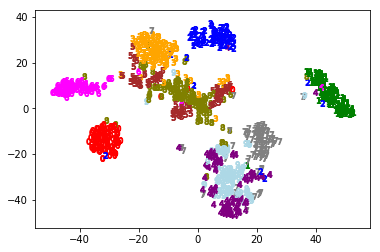

In [514]:
points = TSNE(n_components=2,random_state=0).fit_transform(mus_g.view(-1,latent_dim).cpu().detach().numpy())
drawpoints(points,ts_g.cpu().detach().numpy())

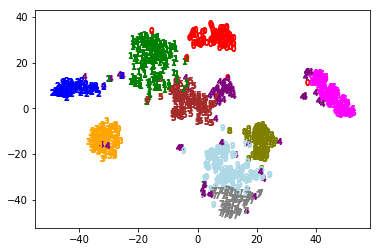

In [515]:
drawpoints(points,torch.argmax(gamma_c_g,2).view(-1).cpu().detach().numpy())

In [516]:
show_generated_samples_c(mu_c_g,logvar_c_g)


In [517]:
train_c_epoch(epochs=3,mu_c=mu_c_g,logvar_c=logvar_c_g,pi_c=pi_c_g)










Train Epoch: 1 [0/60000 (0%)]	Loss: 98.641445
Train Epoch: 1 [1000/60000 (2%)]	Loss: 98.714141
Train Epoch: 1 [2000/60000 (3%)]	Loss: 96.751494
Train Epoch: 1 [3000/60000 (5%)]	Loss: 98.535820
Train Epoch: 1 [4000/60000 (7%)]	Loss: 100.803779
Train Epoch: 1 [5000/60000 (8%)]	Loss: 100.405430
Train Epoch: 1 [6000/60000 (10%)]	Loss: 97.564111
Train Epoch: 1 [7000/60000 (12%)]	Loss: 98.630117
Train Epoch: 1 [8000/60000 (13%)]	Loss: 98.170889
Train Epoch: 1 [9000/60000 (15%)]	Loss: 95.520215
Train Epoch: 1 [10000/60000 (17%)]	Loss: 95.563555
Train Epoch: 1 [11000/60000 (18%)]	Loss: 102.451758
Train Epoch: 1 [12000/60000 (20%)]	Loss: 97.065615
Train Epoch: 1 [13000/60000 (22%)]	Loss: 100.001934
Train Epoch: 1 [14000/60000 (23%)]	Loss: 99.873633
Train Epoch: 1 [15000/60000 (25%)]	Loss: 96.348184
Train Epoch: 1 [16000/60000 (27%)]	Loss: 97.824414
Train Epoch: 1 [17000/60000 (28%)]	Loss: 97.224746
Train Epoch: 1 [18000/60000 (30%)]	Loss: 97.365586
Train Epoch: 1 [19000/60000 (32%)]	Loss: 101.9